#TRABAJO FINAL ANALITICA <br>
##Por: AURA LUZ MORENO DÍAZ


# Datos
Los datos que se utilizará contiene el comportamiento de uso de aproximadamente 9.000 usuarios de tarjetas de crédito en dos periodos de tiempos diferentes.
descripción campos: credit_card_clientes_dictionary.txt
carpeta: https://github.com/juancamiloespana/LEA2/tree/master/_data

Dataset 1: credit_card_clients.csv

La variable ‘PURCHASES’ fue calculada de Ene-Jun de 2023
El resto de las variables fueron calculadas seis meses antes Jul-Dic 2022

Dataset 2: credit_card_clients2.csv

Todas las variables fueron calculadas en el periodo Ene-Jun 2023


Trabajo a desarrollar:

La empresa quiere predecir cuántos será el monto de compras de cada cliente “PURCHASES” en el periodo de Jul-Dic 20223. Esta variable es fundamental para la empresa porque las compras del cliente son proporcionales a los ingresos que genera a la empresa. Con estas predicciones se quieren definir estrategias de fidelización, en el caso de los clientes que mayores compras vayan a tener, y estrategias para mejorar el uso de las tarjetas en los clientes que van a tener menor cantidad de compras.

Dentro de sus análisis tenga en cuenta analizar (como mínimo) los siguientes puntos:

1. Utilizando redes neuronales, entrene el mejor modelo posible que le permita predecir las compras “PURCHASES” que va a tener un cliente en los próximos 6 meses, utilizando la información de 6 meses atrás.
2. Analice el desempeño del modelo entrenado y saque algunas conclusiones.
3. Realice la predicción de las compras “PURCHASES” de los clientes en el periodo Jul-Dic 2023 e identifique el top 10 de clientes que más compras van a tener y top 10 de los clientes que menos compras van a tener.
4. Defina que estrategias implementaría para fidelizar clientes con muchas compras y qué estrategias implementaría para activar clientes que están usando muy poco las tarjetas.



In [171]:
!pip install keras_tuner

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [172]:
url="https://raw.githubusercontent.com/juancamiloespana/LEA2/master/_data/credit_card_clients.csv"
credit_card_data = pd.read_csv(url)

In [173]:
credit_card_data.dropna(inplace=True)

In [174]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8636 non-null   object 
 1   BALANCE                           8636 non-null   float64
 2   BALANCE_FREQUENCY                 8636 non-null   float64
 3   PURCHASES                         8636 non-null   float64
 4   ONEOFF_PURCHASES                  8636 non-null   float64
 5   INSTALLMENTS_PURCHASES            8636 non-null   float64
 6   CASH_ADVANCE                      8636 non-null   float64
 7   PURCHASES_FREQUENCY               8636 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 11  CASH_ADVANCE_TRX                  8636 non-null   int64  
 12  PURCHA

In [175]:
credit_card_data_subset = credit_card_data.sample(n=200)
credit_card_data_subset.to_csv('credit_card_data_subset.csv', index=False)
credit_card_data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 7972 to 2127
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           200 non-null    object 
 1   BALANCE                           200 non-null    float64
 2   BALANCE_FREQUENCY                 200 non-null    float64
 3   PURCHASES                         200 non-null    float64
 4   ONEOFF_PURCHASES                  200 non-null    float64
 5   INSTALLMENTS_PURCHASES            200 non-null    float64
 6   CASH_ADVANCE                      200 non-null    float64
 7   PURCHASES_FREQUENCY               200 non-null    float64
 8   ONEOFF_PURCHASES_FREQUENCY        200 non-null    float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  200 non-null    float64
 10  CASH_ADVANCE_FREQUENCY            200 non-null    float64
 11  CASH_ADVANCE_TRX                  200 non-null    int64  
 12  PURC

In [176]:
y_credit = credit_card_data['PURCHASES']
X_credit = credit_card_data.drop('PURCHASES', axis=1)

In [177]:
numeric_columns = X_credit.select_dtypes(include=[np.number]).columns
X_credit = X_credit[numeric_columns]

In [178]:
scaler = StandardScaler().fit(X_credit)
X_credit_scaled = scaler.transform(X_credit)

In [179]:
#Exportar el escalador
import joblib

joblib.dump(scaler, "/content/drive/MyDrive/Colab Notebooks/ANALITICA 2/TFINAL/sc.joblib")

['/content/drive/MyDrive/Colab Notebooks/ANALITICA 2/TFINAL/sc.joblib']

In [180]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit_scaled, y_credit, test_size=0.2, random_state=42
)

Las redes neuronales están compuestas de varias capas de neuronas. En la capa cero generalmente tenemos los parámetros de entrada y el escalado de las variables<br>
En las capas intermedias u ocultas tenemos funciones de activación para cada una. Los interceptos o BIAS se definen para cada neurona.

En este caso tenemos un problema de **REGRESIÓN** porque estamos tratando de predecir un valor (que es mayor a cero) donde se predicen las **compras**

In [181]:
# Definir la arquitectura del modelo de red neuronal
def build_credit_model(hp):
    dor = hp.Float('DOR', min_value=0.1, max_value=0.6, step=0.1)
    opt = hp.Choice('opt', ['adam', 'sgd'])

    model = keras.models.Sequential([
        keras.layers.Input(shape=(X_credit.shape[1],)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(dor),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="linear")  # Cambiado a 'linear' para problemas de regresión
    ])

    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])
    return model

Aquí estableceremos los parámetros, es decir:


*   Weights o pesos
*   BIAS o Interceptos

Además de esto, Definimos los hiperparámetros de optimización: función de pérdida y la métrica.

También tenemos un learning rate que ajustamos en 0.01 como es la recomendación general.

Y los EPOCH que deben estar entre 5 y 10, para este caso elegimos 10

Entre las métricas tenemos para regresión: RMSE, MAPE y MAE<br>
En este caso, se usa MSE o error cuadrático medio que es muy eficiente para problemas de REGRESIÓN como es el caso de nosotros.

In [182]:
hyperparameters = kt.HyperParameters()
loss = keras.losses.MeanSquaredError()
metric_name = "mean_absolute_error"
metric = keras.metrics.MeanAbsoluteError(name=metric_name)

tuner = kt.RandomSearch(
    hypermodel=build_credit_model,
    hyperparameters=hyperparameters,
    objective=kt.Objective(metric_name, direction="min"),
    max_trials=20,
    overwrite=True,
    project_name="credit_card_results"
)

In [183]:
# Realizar la búsqueda de hiperparámetros
tuner.search(X_credit_train, y_credit_train, epochs=10, validation_data=(X_credit_test, y_credit_test))
tuner.results_summary()

Trial 10 Complete [00h 00m 07s]
mean_absolute_error: nan

Best mean_absolute_error So Far: 308.2114562988281
Total elapsed time: 00h 01m 44s
Results summary
Results in ./credit_card_results
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 07 summary
Hyperparameters:
DOR: 0.1
opt: adam
Score: 308.2114562988281

Trial 05 summary
Hyperparameters:
DOR: 0.30000000000000004
opt: adam
Score: 326.2607727050781

Trial 00 summary
Hyperparameters:
DOR: 0.2
opt: adam
Score: 331.348876953125

Trial 08 summary
Hyperparameters:
DOR: 0.4
opt: adam
Score: 334.2038879394531

Trial 02 summary
Hyperparameters:
DOR: 0.5
opt: adam
Score: 347.2281799316406

Trial 01 summary
Hyperparameters:
DOR: 0.5
opt: sgd
Score: nan

Trial 03 summary
Hyperparameters:
DOR: 0.2
opt: sgd
Score: nan

Trial 04 summary
Hyperparameters:
DOR: 0.1
opt: sgd
Score: nan

Trial 06 summary
Hyperparameters:
DOR: 0.30000000000000004
opt: sgd
Score: nan

Trial 09 summary
Hyperparameters:
DOR: 0.4
opt: s

In [184]:
# Obtener el mejor modelo
best_credit_model = tuner.get_best_models(num_models=1)[0]
best_credit_hps = tuner.get_best_hyperparameters(1)[0]

In [185]:
# Mostrar detalles del mejor modelo
best_credit_model.build()
best_credit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12545 (49.00 KB)
Trainable params: 12545 (49.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [186]:
# Evaluar el modelo en el conjunto de prueba
y_credit_pred = best_credit_model.predict(X_credit_test)
y_credit_actual = np.array(y_credit_test)
y_credit_pred = np.array(y_credit_pred)[:, 0]

54/54 [==============================] - 0s 2ms/step


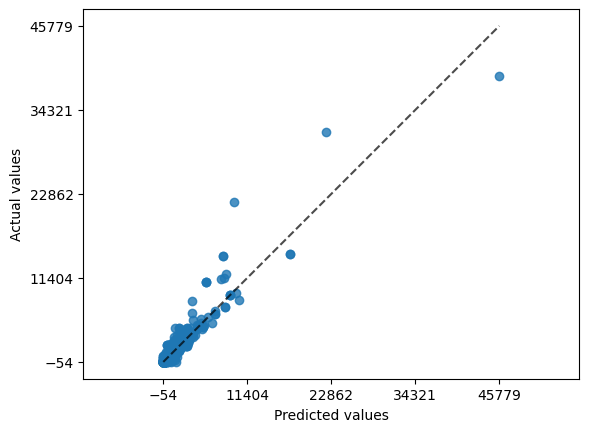

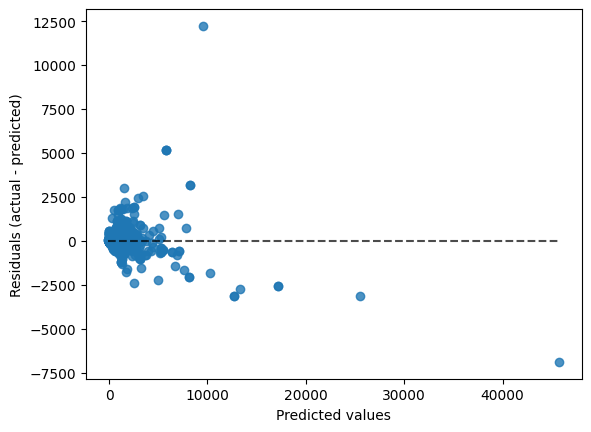

In [187]:
# Mostrar gráficos de evaluación
import sklearn.metrics as metrics
metrics.PredictionErrorDisplay.from_predictions(y_true=y_credit_actual, y_pred=y_credit_pred, kind="actual_vs_predicted")
metrics.PredictionErrorDisplay.from_predictions(y_true=y_credit_actual, y_pred=y_credit_pred, kind="residual_vs_predicted")

In [188]:
# Cargar nuevos datos y hacer predicciones
credit_card_data_new = pd.read_csv("winmodel")
X_new_scaled = scaler.transform(credit_card_data_new)
pred_new_credit = best_credit_model.predict(X_new_scaled)
credit_card_data_new["pred_PURCHASES"] = pred_new_credit

FileNotFoundError: ignored

In [ ]:
# Mostrar los resultados ordenados por predicciones
credit_card_data_new.sort_values('pred_PURCHASES', ascending=False)
